In [1]:
import pandas as pd
import geopandas as gpd

sample = "C://Users//82106//Downloads//_census_data_2021_bnd_dong_bnd_dong_11_2021_2021//bnd_dong_11_2021_2021_2Q.shp"
seoul = gpd.read_file(sample)
seoul = pd.DataFrame(seoul)
seoul = seoul.drop('BASE_DATE',axis=1)
seoul.info()
#seoul

C:\Users\82106\AppData\Local\Programs\Python\Python310\lib\site-packages\geopandas\_compat.py:112: UserWarning: The Shapely GEOS version (3.10.3-CAPI-1.16.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 425 entries, 0 to 424
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   ADM_DR_CD  425 non-null    object  
 1   ADM_DR_NM  425 non-null    object  
 2   geometry   425 non-null    geometry
dtypes: geometry(1), object(2)
memory usage: 10.1+ KB


In [2]:
#읍면동 코드를 기준으로 동 지도데이터와 병합




f = pd.read_table("C://Users//82106//Downloads//_census_reqdoc_1659063002585//original//11_2019년_산업분류별(10차_대분류)_종사자수.txt",sep='^',header=None)
f = f.fillna(0)
f = f.iloc[:,1:]
f.iloc[:,0] = f.iloc[:,0].map(str)
f['읍면동코드'],f['일련번호'] = map(f.iloc[:,0].str.slice,[0,7],[7,12])
#print(f)

d = pd.read_excel("C://Users//82106//Downloads//ref_code//original//adm_code.xls",sheet_name='2019년6월')
d = d[d.iloc[:,0]=='11'] #서울특별시 정보만 추출
d = d.iloc[:,2:] #시도코드, 시도명칭 삭제
#print(d)

g = pd.read_excel("C://Users//82106//Downloads//ref_code//original//statistics_code.xls",sheet_name='집계구')
g = g.iloc[:,2:]
g = g[g.iloc[:,1].str.contains("cp_bem_")] #원하는 종사자수 코드를 가진 row만 추출
g = g.tail(20)
#print(g)



In [3]:

#merge the dataframe
merge1 = pd.merge(f,d,left_on='읍면동코드',right_on=d.iloc[:,2],how='left')
merge1 = merge1.iloc[:,[0,2,3,6,8]]
merge2 = pd.merge(f,g,left_on=f.iloc[:,1],right_on=g.iloc[:,1],how='left')
merge2 = merge2.iloc[:,[1,6]]
jong_sa_ja_soo = pd.concat([merge1,merge2],axis=1,join='inner')
jong_sa_ja_soo = jong_sa_ja_soo.iloc[:,[1,2,3,4,6]]

names = ['종사자수','읍면동코드','구이름','동이름','산업종류']
jong_sa_ja_soo.columns = names
names = names[1:]+names[:1]
jong_sa_ja_soo = jong_sa_ja_soo[names]
jsjs = jong_sa_ja_soo.groupby(['동이름'])['종사자수'].transform(max) == jong_sa_ja_soo['종사자수']
jsjs2 =  jong_sa_ja_soo[jsjs]

jsjs2['읍면동코드'] = jsjs2['읍면동코드'].astype(str)
#jsjs2.info()


jsjs2

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_21624\3304553461.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  jsjs2['읍면동코드'] = jsjs2['읍면동코드'].astype(str)


,읍면동코드,구이름,동이름,산업종류,종사자수
12,1103065,용산구,이태원1동,"공공행정, 국방 및 사회보장 행정",1223.0
13,1114071,마포구,연남동,숙박 및 음식점업,338.0
35,1104068,성동구,성수2가3동,사업시설관리 및 사업지원 서비스업,2768.0
362,1125052,강동구,상일동,보건업 및 사회복지 서비스업,1462.0
498,1115060,양천구,신월4동,운수업,384.0
...,...,...,...,...,...
99760,1103053,용산구,남영동,도매 및 소매업,2018.0
99868,1111073,노원구,상계9동,교육 서비스업,508.0
99873,1113070,서대문구,남가좌2동,교육 서비스업,1488.0
100045,1111059,노원구,하계2동,교육 서비스업,194.0


In [4]:
Geometries = pd.Series(seoul.geometry.values, index=seoul.ADM_DR_CD).to_dict()


from shapely import wkt

def geo(a):
    newcolumn=[]
    for n in a:
        m= Geometries[n]
        newcolumn.append(m)
    return(newcolumn)

jsjs2['Geometry'] = geo(jsjs2['읍면동코드'])
jsjs2

jsjs2['Geometry'] = jsjs2['Geometry'].astype(str)
jsjs2['geometry'] = jsjs2['Geometry'].apply(wkt.loads)
jsjs2_gdf = gpd.GeoDataFrame(jsjs2, crs='epsg:4326')
jsjs2_gdf

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_21624\1380121660.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  jsjs2['Geometry'] = geo(jsjs2['읍면동코드'])
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_21624\1380121660.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  jsjs2['Geometry'] = jsjs2['Geometry'].astype(str)
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_21624\1380121660.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

,읍면동코드,구이름,동이름,산업종류,종사자수,Geometry,geometry
12,1103065,용산구,이태원1동,"공공행정, 국방 및 사회보장 행정",1223.0,"POLYGON ((955410.0464999995 1948935.9952, 9554...","POLYGON ((955410.04650 1948935.99520, 955409.0..."
13,1114071,마포구,연남동,숙박 및 음식점업,338.0,POLYGON ((948525.2735999986 1952195.4750000043...,"POLYGON ((948525.27360 1952195.47500, 948536.1..."
35,1104068,성동구,성수2가3동,사업시설관리 및 사업지원 서비스업,2768.0,POLYGON ((961381.2413000003 1949952.1812000042...,"POLYGON ((961381.24130 1949952.18120, 961391.8..."
362,1125052,강동구,상일동,보건업 및 사회복지 서비스업,1462.0,POLYGON ((971169.9345000001 1949787.7090999999...,"POLYGON ((971169.93450 1949787.70910, 971171.1..."
498,1115060,양천구,신월4동,운수업,384.0,POLYGON ((941722.9341000014 1947674.0304999994...,"POLYGON ((941722.93410 1947674.03050, 941725.5..."
...,...,...,...,...,...,...,...
99760,1103053,용산구,남영동,도매 및 소매업,2018.0,POLYGON ((953128.6609000019 1950682.8037999992...,"POLYGON ((953128.66090 1950682.80380, 953162.7..."
99868,1111073,노원구,상계9동,교육 서비스업,508.0,"POLYGON ((961317.109899998 1963732.5295000067,...","POLYGON ((961317.10990 1963732.52950, 961307.7..."
99873,1113070,서대문구,남가좌2동,교육 서비스업,1488.0,"POLYGON ((949043.5189 1954153.4135999996, 9490...","POLYGON ((949043.51890 1954153.41360, 949053.4..."
100045,1111059,노원구,하계2동,교육 서비스업,194.0,POLYGON ((961291.7103999994 1959844.3993000016...,"POLYGON ((961291.71040 1959844.39930, 961298.3..."


In [7]:
# 한글깨짐 해결
import matplotlib.pyplot as plt

def get_font_family():
    """
    시스템 환경에 따른 기본 폰트명을 반환하는 함수
    """
    import platform
    system_name = platform.system()

    if system_name == "Darwin" :
        font_family = "AppleGothic"
    elif system_name == "Windows":
        font_family = "Malgun Gothic"
    else:
        # Linux(colab)
        !apt-get install fonts-nanum -qq  > /dev/null
        !fc-cache -fv

        import matplotlib as mpl
        mpl.font_manager._rebuild()
        findfont = mpl.font_manager.fontManager.findfont
        mpl.font_manager.findfont = findfont
        mpl.backends.backend_agg.findfont = findfont

        font_family = "S-Core Dream"
    return font_family
# 시각화를 위한 폰트설정
# 위에서 만든 함수를 통해 시스템 폰트를 불러와서 font_family라는 변수에 할당합니다.
plt.style.use("ggplot")

font_family = get_font_family()
# 폰트설정
plt.rc("font", family=font_family)
# 마이너스 폰트 설정
plt.rc("axes", unicode_minus=False)
# 그래프에 retina display 적용
# from IPython.display import set_matplotlib_formats
# set_matplotlib_formats("retina")

%config InlineBackend.figure_format = 'retina'


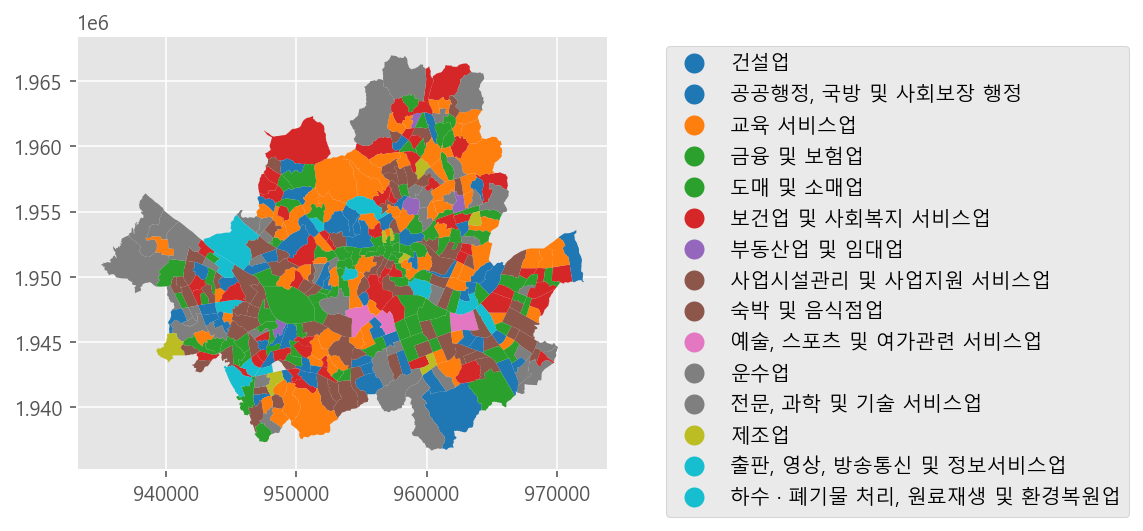

<Figure size 7200x7200 with 0 Axes>

In [10]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,1)
plt.figure(figsize=(100,100))
jsjs_plot = jsjs2_gdf.plot(column='산업종류',ax=ax, aspect=1, legend=True,legend_kwds={'bbox_to_anchor': (2, 1)})

#jsjs_plot
#jsjs_plot.figure.savefig("C://Users//82106//Documents//figures//max_종사자수.png",dpi=300, bbox_inches='tight')